# Figures for simplicial persistent homology

In [1]:
import numpy as np
import pandas as pd

from biperscan import BPSCAN

from lib.plotting import *
from matplotlib.colors import Normalize, to_rgb, ListedColormap
from matplotlib.lines import Line2D

tab10 = configure_matplotlib()

In [5]:
df = pd.read_csv('data/five_circles/five_circles.csv')
x = df.x[0:224:3].to_numpy()
y = df.y[0:224:3].to_numpy() / (1 / 0.618)
pos = np.concatenate((x[np.newaxis].T, y[np.newaxis].T), axis = 1)

## Persistent Homology

In [ ]:
from gtda.plotting import plot_diagram
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1], 
                             reduced_homology=False,
                             n_jobs=1)
diagrams = VR.fit_transform([pos])

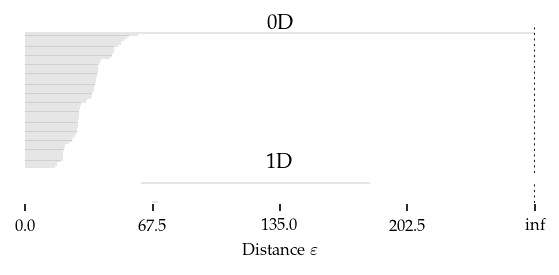

In [19]:
from matplotlib import gridspec


sized_fig(0.66, aspect = 0.618/2/0.66)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1]) 

ylabels = ['Connected components', 'Loops']
ds = [0, 1]
inf_value = 270
for j, d in enumerate(ds):
  ax = plt.subplot(gs[j])
  components = diagrams[0][diagrams[0][:, 2] == d]
  for i, pair in enumerate(components):
    plt.plot([pair[0], pair[1] if not np.isinf(pair[1]) else inf_value], [i, i], 'k-', linewidth=0.1)
  plt.plot([inf_value, inf_value], plt.ylim(), 'k:', linewidth=1)

  plt.yticks([])
  ax.set_title(f'{j}D', y=1, pad=-5 if j == 0 else None)
  plt.xlim([0, inf_value])

  if j == 0:
    ax.set_xticks([])
    plt.xlabel('')
  else:
    ticks = np.linspace(0, inf_value, 5)
    labels = [
      f'{t}' if t != inf_value else 'inf'
      for t in ticks
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    plt.xlabel('Distance $\\varepsilon$')
    
plt.subplots_adjust(0.03, 0.23, .97, .96, hspace=0)
plt.savefig('./images/barcode.pdf', pad_inches=0)
plt.show()

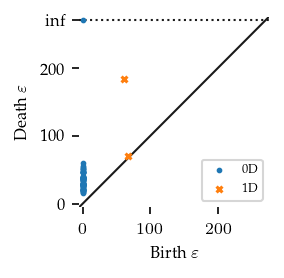

In [20]:
sized_fig(0.33, aspect=0.618 / 2 / 0.33)

markers = ["o", "x"]

for i, d in enumerate(ds):
    components = diagrams[0][diagrams[0][:, 2] == d]
    components[np.isinf(components[:, 1]), 1] = inf_value
    plt.scatter(
        components[:, 0],
        components[:, 1],
        s=3 if i == 0 else 8,
        marker=markers[i],
    )


lim = [-5, inf_value + 5]
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, [inf_value, inf_value], "k:", linewidth=1, zorder=-1)
plt.plot(lim, lim, "k-", linewidth=1, zorder=-1)
plt.legend(['0D', '1D'], loc='lower right')
plt.xlabel("Birth $\\varepsilon$")
plt.ylabel("Death $\\varepsilon$")
plt.gca().set_yticks([0, 100, 200, inf_value])
plt.gca().set_yticklabels(['0', '100', '200', 'inf'])
plt.subplots_adjust(0.28, 0.23, .98, .98)
plt.savefig('./images/diagram.pdf', pad_inches=0)
plt.show()

## Vietoris-Rips complexes

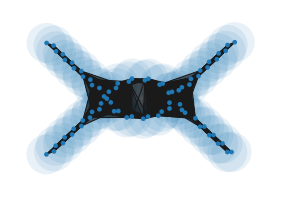

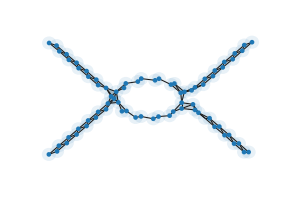

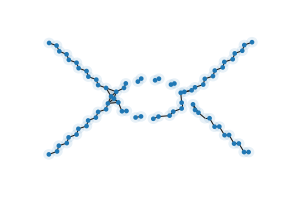

In [18]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
import networkx as nx

dists = pdist(pos)
dists_list = np.sort(dists)

xlim = None
ylim = None

for threshold in [95, 31, 25]:
    edges = dists < (threshold * 2)
    edges = coo_matrix(squareform(edges))
    edges.eliminate_zeros()
    g = nx.Graph(edges)

    faces = []
    for source in range(edges.shape[0]):
        for neighbor in g.neighbors(source):
            for second_degree in g.neighbors(neighbor):
                if source in g.neighbors(second_degree):
                    faces.append((source, neighbor, second_degree))

    poly = [
        [
            (x[faces[i][0]], y[faces[i][0]]),
            (x[faces[i][1]], y[faces[i][1]]),
            (x[faces[i][2]], y[faces[i][2]]),
        ]
        for i in range(len(faces))
    ]

    fig = sized_fig(0.33)
    ax = plt.gca()

    edge_list, _ = zip(*nx.get_edge_attributes(g, "weight").items())
    edge_colors = [(x[e[0]] + x[e[1]]) / 2 for e in edge_list]
    node_list = list(range(edges.col.max()))
    node_colors = x[node_list]

    for i in range(len(x)):
        ax.add_patch(
            plt.Circle(
                (x[i], y[i]),
                threshold,
                facecolor="C0",
                alpha=0.1,
                zorder=-2,
                linewidth=0,
                edgecolor="none",
            )
        )

    for face in range(len(faces)):
        p = plt.Polygon(poly[face], fc="k", ec="none", alpha=0.015, zorder=-1)
        ax.add_patch(p)

    nx.draw_networkx(
        g,
        pos=pos,
        ax=ax,
        edgelist=edge_list,
        nodelist=node_list,
        edge_color="k",
        node_color="C0",
        width=0.5,
        node_size=5,
        with_labels=False,
        linewidths=0,
        edgecolors="none",
    )

    plt.axis("off")
    if xlim is None:
        ax.set_aspect("equal")
        xlim = plt.xlim()
        ylim = plt.ylim()
    else:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.subplots_adjust(0, 0, 1, 1)
    plt.savefig(f"./images/vietoris_rips_{threshold}.pdf", pad_inches=0)
    plt.show()

## Minimal Simplicial Complex

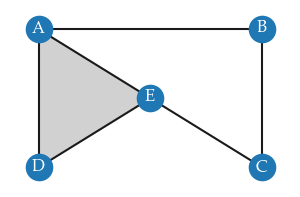

In [ ]:
X = np.array([[0, 1], [2, 1], [2, 0], [0, 0], [1, 0.5]])
edges = np.array([[0, 1], [1, 2], [3, 0], [0, 4], [2, 4], [3, 4]])
faces = np.array([[0, 3, 4]])

g = nx.from_edgelist(edges)
letters = ["A", "B", "C", "D", "E"]

sized_fig(0.33)
for face in faces:
    poly = plt.Polygon(
        np.asarray([X[face[0]], X[face[1]], X[face[2]]]),
        fc="k",
        ec="none",
        alpha=0.2,
        zorder=-1,
    )
    plt.gca().add_patch(poly)

nx.draw_networkx(
    g,
    pos=X,
    node_size=150,
    with_labels=True,
    labels={i: letters[i] for i in range(X.shape[0])},
    font_color="w",
    font_size=8,
)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./images/simple_complex.pdf", pad_inches=0)